In [4]:
## Importar librerias necesarias
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import duckdb

In [5]:
periodo = 365

macrozona_norte = """(1,2,3,4)"""
macrozona_centro = """(5,6,7,8)"""
region_metropolitana = """(9,10,11,12,13,14)"""
macrozona_centro_sur = """(15,16,17,18,19,20,28)"""
macrozona_sur = """(21,22,23,24,29,33)"""
macrozona_austral = """(25,26)"""

grupos_etarios = ["Menores_1","De_1_a_4","De_5_a_14","De_15_a_64","De_65_y_mas"]

lista_zonas = ["MacrozonaNorte",
               "MacrozonaCentro",
               "RegionMetropolitana",
               "MacrozonaCentroSur",
               "MacrozonaSur",
               "MacrozonaAustral"]

lista_zonas_legend = ["Macrozona Norte",
               "Macrozona Centro",
               "Region Metropolitana",
               "Macrozona Centro-Sur",
               "Macrozona Sur",
               "Macrozona Austral"]

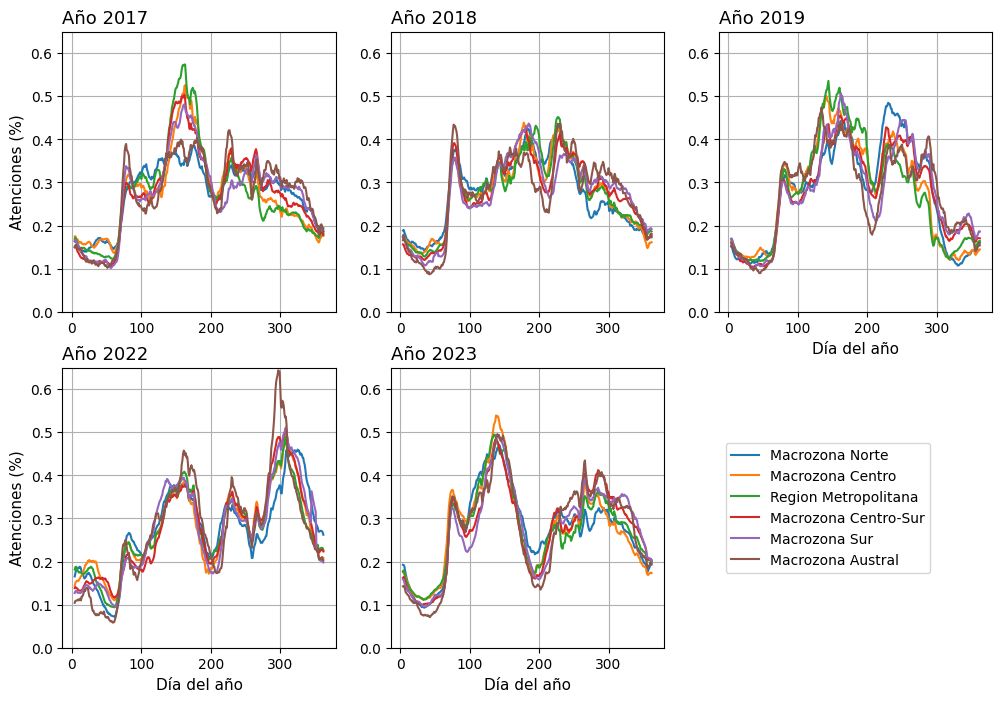

In [6]:
#Genera una comparación de las atenciones diarias correspondiente 
# a diferentes regiones geográficas. Las zonas están determinadas 
# por lo servicios de salud que las componen
# en los gráficos se muestra la información para diferentes años

def common_filter_zona(zona):
    return """
FROM datos_urgencia_consolidados.parquet
where IdCausa in (3,4,5,6,10,11)
--and year(strptime(fecha, '%d/%m/%Y')) in (2017,2018,2019,2022,2023)
and CodigoDependencia in """ + zona +"""
--group by CodigoDependencia, fecha
group by zona, fecha
""" + """
having dayofyear(strptime(fecha, '%d/%m/%Y')) <= """+ str(periodo) + """
"""

#here CodigoDependencia indicates the "Servicio de Salud"
#to ignote the grouping by "region"  set "CodigoRegion" to a constant and remove it from the group by
df2 = duckdb.sql("""
select year(strptime(fecha, '%d/%m/%Y')) as year
--    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'MacrozonaNorte' as zona
--    , 'Menores_1' as grupo_etario
    , sum(Menores_1) + sum(De_1_a_4) + sum(De_5_a_14) + sum(De_15_a_64)  + sum(De_65_y_mas) as atenciones
"""+ common_filter_zona(macrozona_norte) + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
--    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'MacrozonaCentro' as zona
--    ,'De_1_a_4' as grupo_etario
    , sum(Menores_1) + sum(De_1_a_4) + sum(De_5_a_14) + sum(De_15_a_64)  + sum(De_65_y_mas) as atenciones
"""+ common_filter_zona(macrozona_centro)  + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
--    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'RegionMetropolitana' as zona
--    , 'De_5_a_14' as grupo_etario
    , sum(Menores_1) + sum(De_1_a_4) + sum(De_5_a_14) + sum(De_15_a_64)  + sum(De_65_y_mas) as atenciones
"""+ common_filter_zona(region_metropolitana)  + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
--    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'MacrozonaCentroSur' as zona
--    , 'De_15_a_64'  as grupo_etario
    , sum(Menores_1) + sum(De_1_a_4) + sum(De_5_a_14) + sum(De_15_a_64)  + sum(De_65_y_mas) as atenciones
"""+ common_filter_zona(macrozona_centro_sur)  + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
--    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'MacrozonaSur' as zona
--    , 'De_15_a_64'  as grupo_etario
    , sum(Menores_1) + sum(De_1_a_4) + sum(De_5_a_14) + sum(De_15_a_64)  + sum(De_65_y_mas) as atenciones
"""+ common_filter_zona(macrozona_sur)  + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
--    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'MacrozonaAustral' as zona
--    , 'De_65_y_mas' as grupo_etario
    , sum(Menores_1) + sum(De_1_a_4) + sum(De_5_a_14) + sum(De_15_a_64)  + sum(De_65_y_mas) as atenciones
"""+ common_filter_zona(macrozona_austral) + """
""").df()

df2 = df2.sort_values(by=['zona','year','nrodia']).reset_index(drop = True)


# ILUSTRACIÓN 1 ATENCIONES DIARIAS DE URGENCIA PARA 
# CADA DÍA DEL AÑO CORRESPONDIENTES AL PERIODO 2017 -2023 para diferentes zonas geográficas 
fig = plt.figure(figsize = (12,8))
year_list=[2017,2018,2019,2022,2023]

for k in range(5):
    df3 =df2[df2["year"]==year_list[k]]
    ax = fig.add_subplot(2,3,k+1) 
    df_dict = {key[0]: d for key, d in df3[['zona','year','nrodia','atenciones']].groupby(['zona'])}

    ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
    for key in lista_zonas:
        plt.plot(df_dict[key]['nrodia'],100*df_dict[key]['atenciones'].rolling(7,center=True).mean()/float(sum(df_dict[key]['atenciones'])) )
    ax.set_ylim(ymin=0)
    ax.set_ylim(ymax=0.65)
    ax.grid()
    ax.set_title('Año ' + str(year_list[k]) , fontsize = 13, loc='left')
    if k in (2,3,4):
       ax.set_xlabel('Día del año', fontsize = 11)
    if k in (0,3):
        ax.set_ylabel('Atenciones (%)', fontsize = 11)

#show legend in last plot space
ax = fig.add_subplot(2,3,6) 
ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
for key in lista_zonas:
    plt.plot(range(1),range(1))


ax.legend(lista_zonas_legend,loc='center left',fontsize = 10 )
#ax.clear()
#ax.legend(h, l, loc='upper left')
ax.axis('off')
#ax.legend(targets,loc='upper left',fontsize = 12 )

plt.savefig('fig3_v2_urgencias_geografica_años.png', bbox_inches='tight')


